# CNN Applied to EEG Data to classify subject 1 data


## Preparation and Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pwd

'/content'

In [3]:
% cd 'drive/My Drive/ECE C147'
% cd 'project'
% ls


/content/drive/My Drive/ECE C147
/content/drive/My Drive/ECE C147/project
EEG_loading.ipynb  person_train_valid.npy  X_train_valid.npy  y_train_valid.npy
person_test.npy    X_test.npy              y_test.npy


In [4]:
def count_parameters(model):
  """Function for count model's parameters"""
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import transforms, utils
import time

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

# get the device type of machine
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [9]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


# adjust labels 
y_train_valid -= 769
y_test -= 769


print('y_train_valid', y_train_valid[:10])

y_train_valid [2 3 0 0 0 0 2 1 3 3]


In [44]:
#filter data for subject 1 only

train_val_subject1_idx =  []
for i, n in enumerate(person_train_valid):
  if n==0:
    train_val_subject1_idx.append(i)
X_train_val_subject1 = X_train_valid[train_val_subject1_idx]
y_train_val_subject1 = y_train_valid[train_val_subject1_idx]
print(len(y_train_val_subject1))
test_subject1_index = []
for i, n in enumerate(person_test):
  if n==0:
    test_subject1_index.append(i)
print(test_subject1_index)
X_test_subject1 = X_test[test_subject1_index]
y_test_subject1 = y_test[test_subject1_index]
print(len(y_test_subject1))

237
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
50


In [45]:


# copy numpy data to tensor

X_train_valid_tensor = torch.from_numpy(X_train_valid).float().to(device)
X_train_valid_s1_tensor = torch.from_numpy(X_train_val_subject1).float().to(device)
y_train_valid_tensor = torch.from_numpy(y_train_valid).float().long().to(device) # do not forget .long()
y_train_valid_s1_tensor = torch.from_numpy(y_train_val_subject1).float().long().to(device)
X_test_tensor = torch.from_numpy(X_test_subject1).float().to(device)
y_test_tensor = torch.from_numpy(y_test_subject1).float().long().to(device)


# # convert int labels to one hot labels
# y_train_valid_tensor = nn.functional.one_hot(y_train_valid_tensor)
# print('y_train_valid_onehot', y_train_valid_tensor[:10])

In [46]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid for s1 data shape: {}'.format(X_train_val_subject1.shape))
print ('Test data shape: {}'.format(X_test_subject1.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Training/Valid for s1 target shape: {}'.format(y_train_val_subject1.shape))
print ('Test target shape: {}'.format(y_test_subject1.shape))
#print ('Person train/valid shape: {}'.format(person_train_valid.shape))
#print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Training/Valid for s1 data shape: (237, 22, 1000)
Test data shape: (50, 22, 1000)
Training/Valid target shape: (2115,)
Training/Valid for s1 target shape: (237,)
Test target shape: (50,)


In [47]:
class EEGDataset(Dataset):
    """EEG dataset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
          pass 
            # x = self.transform(x)
            # y = self.transform(y)
        return x, y
        
    def __len__(self):
        return len(self.subset)

init_dataset = TensorDataset(X_train_valid_tensor, y_train_valid_tensor) 
init_s1_dataset = TensorDataset(X_train_valid_s1_tensor,y_train_valid_s1_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)
# split train and val
lengths = [int(len(init_dataset)*0.8), int(len(init_dataset)*0.2)] 
print(lengths)
subset_train, subset_val = random_split(init_dataset, lengths) 
lengths_s1 = [int(len(init_s1_dataset)*0.8), 237-int(len(init_s1_dataset)*0.8)] 
print(lengths_s1)
subset_train_s1,subset_val_s1 = random_split(init_s1_dataset,lengths_s1)
train_data = EEGDataset(
    subset_train, transform=None)


val_data = EEGDataset(
    subset_val, transform=None)

train_data_s1 = EEGDataset(subset_train_s1,transform=None)
val_data_s1 = EEGDataset(subset_val_s1,transform=None)

test_data=EEGDataset(test_dataset,transform=None)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True, num_workers=0),
    'train_s1': torch.utils.data.DataLoader(train_data_s1, batch_size=32, shuffle=True, num_workers=0),
    'val_s1': torch.utils.data.DataLoader(val_data_s1, batch_size=32, shuffle=True, num_workers=0),
    'test':torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
}

[1692, 423]
[189, 48]


## Model

In [48]:
class ShallowConv(nn.Module):
    
    # Defining the building blocks of shallow conv net
    
    def __init__(self, in_channels, num_conv_filters, num_samples_frame, num_eeg_channels,classes):
    
        # Defining as a subclass
        super(ShallowConv, self).__init__()

        self.num_samples_frame = num_samples_frame
        self.num_conv_filters = num_conv_filters
        self.num_eeg_channels = num_eeg_channels
        
        # Define the convolution layer, https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(in_channels, self.num_conv_filters, (1, 25), stride=1)
        self.conv_output_width =  int(self.num_samples_frame - (25-1) - 1 + 1)
        
        # Define the 2d batchnorm layer
        self.bnorm2d = nn.BatchNorm2d(self.num_conv_filters)
        
        # Define the 1d batchnorm layer
        self.bnorm1d = nn.BatchNorm1d(self.num_conv_filters)


        # Define the fc layer, https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.fc1 = nn.Linear(self.num_eeg_channels*self.num_conv_filters, self.num_conv_filters)
        
        # Define the elu activation
        self.elu = nn.ELU(0.2)

        # Define the avg pooling layer
        self.avgpool = nn.AvgPool1d(75, stride=15)
        
        self.num_features_linear = int(np.floor(((self.conv_output_width - 75)/15)+1))
        
        

        # Define the fc layer for generating the scores for classes 
        self.fc2 = nn.Linear(self.num_features_linear*self.num_conv_filters, classes)

        # Define the softmax layer for converting the class scores to probabilities
        self.softmax = nn.Softmax(dim=1)
        
    # Defining the connections of shallow conv net
    
    def forward(self, x):
        
        # Reshaping the input for 2-D convolution (B,22,num_samples_frame) -> (B,1,22,num_samples_frame)
        
        x = x.view(-1, 1, 22, self.num_samples_frame)
        
        # Performing the 2-D convolution (B,1,22,300) -> (B,40,22,x_shape_4dim)
        
        x = self.conv1(x)
        x_shape_4dim = x.shape[3]
        
        # ELU activation
        
        x = self.elu(x)
        
        # 2d Batch normalization
        
        x = self.bnorm2d(x)
        
        
        # Reshaping the input to dense layer (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,880)
        
        x = x.permute(0,3,1,2) # (B,40,22,x_shape_4dim) -> (B,x_shape_4dim,40,22)
        x = x.view(-1,x_shape_4dim,880)
        
        # Passing through the dense layer (B,x_shape_4dim,880) -> (B,x_shape_4dim,40)
        
        x = self.fc1(x)
        
        # ELU activation
        
        x = self.elu(x)
        
        # Square activation
        
        x = torch.square(x)
        
        # Reshaping the input for average pooling layer (B,x_shape_4dim,40) -> (B,40,x_shape_4dim)
        
        x = x.permute(0,2,1)
        
        # Passing through the average pooling layer (B,40,x_shape_4dim) -> (B,40,x_pool_3dim)
        
        x = self.avgpool(x)
        x_pool_3dim = x.shape[2]
        
        # Log activation
        
        x = torch.log(x)
        
        # 1D Batch normalization
        
        x = self.bnorm1d(x)
        #print(x.shape)
        
        # Reshaping the input to dense layer (B,40,x_pool_3dim) -> (B,40*x_pool_3dim)
        
        x = x.reshape(-1, 40*x_pool_3dim)
        
        # Passing through the dense layer (B,40*x_pool_3dim) -> (B,classes)
        
        x = self.fc2(x)
        
        # Passing through the softmax layer
        
        x = self.softmax(x)
        
        return x




In [49]:
## train a model to classify subject1 with data from all subjects
def train_model_with_alldata(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train', 'val']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later

            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))


        prefix = ''
        if phase == 'val':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

In [62]:
# train a model to classify subject 1 data with only subject 1 data

def train_model_with_s1data(model, optimizer, num_epochs):
    # for each epoch... 
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      logs = {}

      # let every epoch go through one training cycle and one validation cycle
      # TRAINING AND THEN VALIDATION LOOP...
      for phase in ['train_s1', 'val_s1']:
        train_loss = 0
        correct = 0
        total = 0
        batch_idx = 0

        start_time = time.time()
        # first loop is training, second loop through is validation
        # this conditional section picks out either a train mode or validation mode
        # depending on where we are in the overall training process
        # SELECT PROPER MODE- train or val
        if phase == 'train_s1':
          for param_group in optimizer.param_groups:
            print("LR", param_group['lr']) # print out the learning rate
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode
        
        for inputs, labels in dataloaders[phase]:
          #print(inputs.size())
          #print(labels.size())
          inputs = inputs.to(device)
          labels = labels.to(device)
          batch_idx += 1
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(phase == 'train_s1'):
          #    the above line says to disable gradient tracking for validation
          #    which makes sense since the model is in evluation mode and we 
          #    don't want to track gradients for validation)
            outputs = model(inputs)
            # compute loss where the loss function will be defined later
            #print(outputs.size())
            



            loss = loss_fn(outputs, labels)
            # backward + optimize only if in training phase
            if phase == 'train_s1':
              loss.backward()
              optimizer.step()
            train_loss += loss
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # if phase == 'train':
        #   if  epoch%5 == 0:
        #   # prints for training and then validation (since the network will be in either train or eval mode at this point) 
        #     print(" Training Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))

        # if phase == 'val' and epoch%5 == 0:
        #   print(" Validation Epoch %d, Total loss %0.6f, iteration time %0.6f" % (epoch, train_loss, time.time() - start_time))


        prefix = ''
        if phase == 'val_s1':
            prefix = 'val_'
        
        logs[prefix + 'loss'] = train_loss.item()/(batch_idx)
        logs[prefix + 'acc'] = correct/total*100.

      liveloss.update(logs)
      liveloss.send()

    # end of single epoch iteration... repeat of n epochs  
    return model

In [63]:
def test(model):
    dataloader = dataloaders['test']
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Train the Model with only subject 1 data and then classify subject 1 data

In [68]:
# define the hyperparamters
weight_decay = 0.15  # weight decay to alleviate overfiting

model = ShallowConv(in_channels=1, num_conv_filters=40,num_samples_frame=1000,num_eeg_channels=22,classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5, weight_decay=weight_decay)

model parameters amount 46204


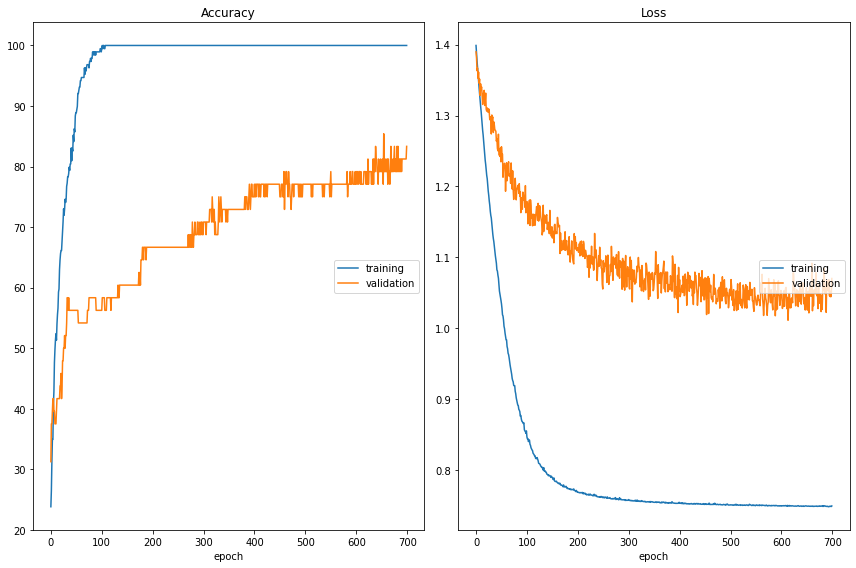

Accuracy
	training         	 (min:   23.810, max:  100.000, cur:  100.000)
	validation       	 (min:   31.250, max:   85.417, cur:   83.333)
Loss
	training         	 (min:    0.748, max:    1.399, cur:    0.750)
	validation       	 (min:    1.011, max:    1.390, cur:    1.070)
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.021682 



In [69]:
model=train_model_with_s1data(model, optimizer, num_epochs=700)
test(model)

## Train the model with all data and then then classify subject 1 data

In [73]:
weight_decay = 0.15  # weight decay to alleviate overfiting

model = ShallowConv(in_channels=1, num_conv_filters=40,num_samples_frame=1000,num_eeg_channels=22,classes=4).to(device)

count = count_parameters(model)
print ('model parameters amount {}'.format(count))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)

model parameters amount 46204


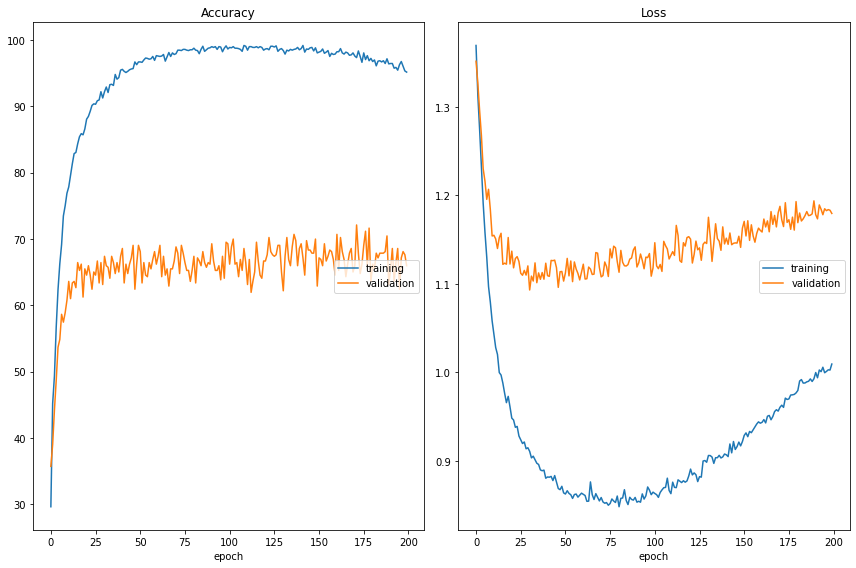

Accuracy
	training         	 (min:   29.610, max:   99.173, cur:   95.154)
	validation       	 (min:   35.697, max:   72.104, cur:   65.957)
Loss
	training         	 (min:    0.848, max:    1.369, cur:    1.009)
	validation       	 (min:    1.093, max:    1.351, cur:    1.179)
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.023357 



In [74]:
model=train_model_with_alldata(model, optimizer, num_epochs=200)
test(model)